# Analysis

This notebook shows the analysis for the paper "Measuring OpenStreetMap building footprint completeness using human settlement layers".

### Setup

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats.stats import pearsonr

In [3]:
phl_pixels_all = pd.read_csv("../data/phl_pixels_all.csv")
phl_poverty = pd.read_csv("../data/phl_poverty_incidence.csv")

In [4]:
phl_pixels_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5500996 entries, 0 to 5500995
Data columns (total 5 columns):
 #   Column           Dtype 
---  ------           ----- 
 0   index            int64 
 1   ADM3_PCODE       object
 2   RURBAN           object
 3   ADM4_PCODE_NAME  object
 4   status           object
dtypes: int64(1), object(4)
memory usage: 209.8+ MB


In [5]:
phl_pixels_all.head()

,index,ADM3_PCODE,RURBAN,ADM4_PCODE_NAME,status
0,1,PH020902000,R,020902010_Santa Rosa (Kaynatuan),mapped
1,3,PH020902000,R,020902010_Santa Rosa (Kaynatuan),mapped
2,4,PH020902000,R,020902010_Santa Rosa (Kaynatuan),mapped
3,5,PH020902000,R,020902010_Santa Rosa (Kaynatuan),mapped
4,8,PH020902000,R,020902010_Santa Rosa (Kaynatuan),mapped


In [6]:
phl_pixels_all.status.unique()

array(['mapped', 'unmapped'], dtype=object)

In [7]:
phl_pixels_all.RURBAN.unique()

array(['R', 'U', nan, '-'], dtype=object)

In [8]:
phl_pixels_all["RURBAN"].unique()

array(['R', 'U', nan, '-'], dtype=object)

In [9]:
phl_pixels_all.loc[phl_pixels_all["RURBAN"] != "-"].loc[
    phl_pixels_all["RURBAN"].notnull()
].groupby(["RURBAN", "status"]).count()

index  ADM3_PCODE  ADM4_PCODE_NAME
RURBAN status                                        
R      mapped     992074      992074           992074
       unmapped  2600890     2600890          2600890
U      mapped     736423      736423           736423
       unmapped  1168036     1168036          1168036

In [10]:
phl_pixels_all.loc[phl_pixels_all["RURBAN"] != "-"].loc[
    phl_pixels_all["RURBAN"].notnull()
].groupby(["RURBAN", "status", "ADM3_PCODE"]).count()

index  ADM4_PCODE_NAME
RURBAN status   ADM3_PCODE                         
R      mapped   PH012801000    183              183
                PH012802000   2964             2964
                PH012803000   2258             2258
                PH012804000   1572             1572
                PH012805000   3789             3789
...                            ...              ...
U      unmapped PH175319000    556              556
                PH175320000   1068             1068
                PH175323000   1912             1912
                PH175324000    740              740
                PH175910000     65               65

[4662 rows x 2 columns]

### Histogram of Barangay Completeness

In [11]:
by_adm4_count = (
    phl_pixels_all.loc[phl_pixels_all["RURBAN"] != "-"]
    .loc[phl_pixels_all["RURBAN"].notnull()]
    .groupby(["ADM4_PCODE_NAME", "status", "RURBAN"])
    .count()
    .reset_index()
)

In [12]:
by_adm4_count.head(1)

,ADM4_PCODE_NAME,status,RURBAN,index,ADM3_PCODE
0,012801001_Adams (Pob.),mapped,R,183,183


In [13]:
adm4_mapped = by_adm4_count.loc[
    by_adm4_count.status == "mapped", ["ADM4_PCODE_NAME", "index", "RURBAN"]
].rename(columns={"index": "mapped_count"})

In [14]:
adm4_unmapped = by_adm4_count.loc[
    by_adm4_count.status == "unmapped", ["ADM4_PCODE_NAME", "index", "RURBAN"]
].rename(columns={"index": "unmapped_count"})

In [15]:
adm4_completeness = adm4_mapped[["ADM4_PCODE_NAME", "mapped_count", "RURBAN"]].merge(
    adm4_unmapped[["ADM4_PCODE_NAME", "unmapped_count", "RURBAN"]],
    on=["ADM4_PCODE_NAME", "RURBAN"],
    how="outer",
)
adm4_completeness.mapped_count = adm4_completeness.mapped_count.fillna(0)
adm4_completeness.unmapped_count = adm4_completeness.unmapped_count.fillna(0)

In [16]:
adm4_completeness["adm4_completeness"] = (
    adm4_completeness.mapped_count
    / (adm4_completeness.mapped_count + adm4_completeness.unmapped_count)
) * 100

In [17]:
adm4_completeness.describe()

,mapped_count,unmapped_count,adm4_completeness
count,41665.000000,41665.000000,41665.000000
mean,41.485587,90.457842,32.084048
std,102.558068,142.700784,36.476193
min,0.000000,0.000000,0.000000
25%,0.000000,15.000000,0.000000
50%,7.000000,43.000000,9.433962
75%,42.000000,109.000000,68.831169
max,3028.000000,4089.000000,100.000000


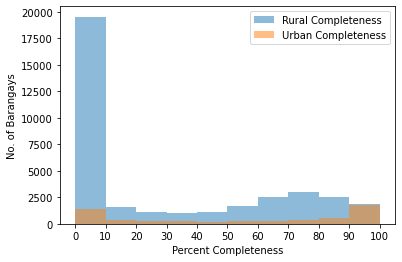

In [18]:
bins = np.linspace(0, 100, 11)

plt.hist(
    adm4_completeness[adm4_completeness.RURBAN == "R"].adm4_completeness,
    bins,
    alpha=0.5,
    label="Rural Completeness",
)
plt.hist(
    adm4_completeness[adm4_completeness.RURBAN == "U"].adm4_completeness,
    bins,
    alpha=0.5,
    label="Urban Completeness",
)
plt.xticks(np.arange(0, 110, 10))
plt.xlabel("Percent Completeness")
plt.ylabel("No. of Barangays")
plt.legend(loc="upper right")
# plt.savefig('urban-rural-histogram.png', dpi=300)

### Urban Pixels Mapped vs Rural Pixels Mapped

In [19]:
by_adm3_count = (
    phl_pixels_all.loc[phl_pixels_all["RURBAN"] != "-"]
    .loc[phl_pixels_all["RURBAN"].notnull()]
    .groupby(["ADM3_PCODE", "status", "RURBAN"])
    .count()
    .reset_index()
)

In [20]:
by_adm3_count.head(1)

,ADM3_PCODE,status,RURBAN,index,ADM4_PCODE_NAME
0,PH012801000,mapped,R,183,183


In [21]:
adm3_mapped = by_adm3_count.loc[
    by_adm3_count.status == "mapped", ["ADM3_PCODE", "index", "RURBAN"]
].rename(columns={"index": "mapped_count"})

In [22]:
adm3_unmapped = by_adm3_count.loc[
    by_adm3_count.status == "unmapped", ["ADM3_PCODE", "index", "RURBAN"]
].rename(columns={"index": "unmapped_count"})

In [23]:
adm3_completeness = adm3_mapped[["ADM3_PCODE", "mapped_count", "RURBAN"]].merge(
    adm3_unmapped[["ADM3_PCODE", "unmapped_count", "RURBAN"]],
    on=["ADM3_PCODE", "RURBAN"],
    how="outer",
)
adm3_completeness.mapped_count = adm3_completeness.mapped_count.fillna(0)
adm3_completeness.unmapped_count = adm3_completeness.unmapped_count.fillna(0)

In [24]:
adm3_completeness["adm3_completeness"] = (
    adm3_completeness.mapped_count
    / (adm3_completeness.mapped_count + adm3_completeness.unmapped_count)
) * 100

In [25]:
adm3_completeness.describe()

,mapped_count,unmapped_count,adm3_completeness
count,2396.000000,2396.000000,2396.000000
mean,721.409432,1573.007513,29.876164
std,1735.507496,2205.398764,31.456789
min,0.000000,0.000000,0.000000
25%,30.000000,371.750000,2.293304
50%,161.500000,918.500000,13.034282
75%,718.750000,1996.750000,61.795975
max,46633.000000,42062.000000,100.000000


In [26]:
rurban_completeness = adm3_completeness.loc[
    adm3_completeness.RURBAN == "R", ["ADM3_PCODE", "adm3_completeness"]
].merge(
    adm3_completeness.loc[
        adm3_completeness.RURBAN == "U", ["ADM3_PCODE", "adm3_completeness"]
    ],
    on="ADM3_PCODE",
    how="inner",
)

In [27]:
rurban_completeness.rename(
    columns={
        "adm3_completeness_x": "rural_complete",
        "adm3_completeness_y": "urban_complete",
    },
    inplace=True,
)

Text(0, 90, '$r^{2}$ = 0.81')

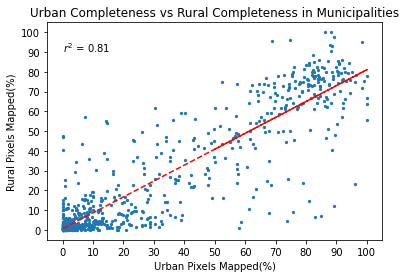

In [28]:
x = rurban_completeness.urban_complete
y = rurban_completeness.rural_complete
correlation_matrix = np.corrcoef(x, y)
correlation_xy = correlation_matrix[0, 1]
r = correlation_xy ** 2

plt.scatter(x, y, s=5)
plt.xlabel("Urban Pixels Mapped(%)")
plt.ylabel("Rural Pixels Mapped(%)")
plt.title("Urban Completeness vs Rural Completeness in Municipalities")
plt.xticks(np.arange(0, 110, 10))
plt.yticks(np.arange(0, 110, 10))
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x, p(x), "r--")
plt.text(0, 90, "$r^{2}$ = " + str(round(r, 2)))
# plt.savefig('urban-rural-completeness.png', dpi=300)

### Urban/Rural Pixels Mapped vs Municipal Completeness

In [29]:
munic_count = (
    phl_pixels_all.loc[phl_pixels_all["RURBAN"] != "-"]
    .loc[phl_pixels_all["RURBAN"].notnull()]
    .groupby(["ADM3_PCODE", "status"])
    .count()
    .reset_index()
)

In [30]:
munic_count.head(1)

,ADM3_PCODE,status,index,RURBAN,ADM4_PCODE_NAME
0,PH012801000,mapped,183,183,183


In [31]:
munic_mapped = munic_count.loc[
    munic_count.status == "mapped", ["ADM3_PCODE", "index"]
].rename(columns={"index": "mapped_count"})

In [32]:
munic_unmapped = munic_count.loc[
    munic_count.status == "unmapped", ["ADM3_PCODE", "index"]
].rename(columns={"index": "unmapped_count"})

In [33]:
munic_completeness = munic_mapped[["ADM3_PCODE", "mapped_count"]].merge(
    munic_unmapped[["ADM3_PCODE", "unmapped_count"]], on=["ADM3_PCODE"], how="outer"
)
munic_completeness.mapped_count = munic_completeness.mapped_count.fillna(0)
munic_completeness.unmapped_count = munic_completeness.unmapped_count.fillna(0)

In [34]:
munic_completeness["munic_completeness"] = (
    munic_completeness.mapped_count
    / (munic_completeness.mapped_count + munic_completeness.unmapped_count)
) * 100

In [35]:
munic_completeness.describe()

,mapped_count,unmapped_count,munic_completeness
count,1645.000000,1645.000000,1645.000000
mean,1050.758055,2291.140426,30.363111
std,2318.185096,3099.872678,30.722180
min,0.000000,11.000000,0.000000
25%,51.000000,625.000000,2.577931
50%,289.000000,1361.000000,14.632502
75%,1047.000000,2855.000000,62.309469
max,46633.000000,56365.000000,98.710434


In [41]:
munic_completeness = munic_completeness[["ADM3_PCODE", "munic_completeness"]].merge(
    rurban_completeness, on="ADM3_PCODE", how="inner"
)

Text(0, 90, '$r^{2}$ = 0.94')

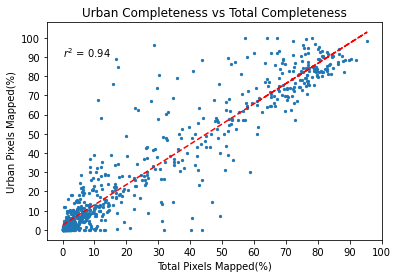

In [42]:
x = munic_completeness.munic_completeness
y = munic_completeness.urban_complete
r, _ = pearsonr(x, y)

plt.scatter(x, y, s=5)
plt.xlabel("Total Pixels Mapped(%)")
plt.ylabel("Urban Pixels Mapped(%)")
plt.title("Urban Completeness vs Total Completeness")
plt.xticks(np.arange(0, 110, 10))
plt.yticks(np.arange(0, 110, 10))
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x, p(x), "r--")
plt.text(0, 90, "$r^{2}$ = " + str(round(r, 2)))
# plt.savefig('urban-total-completeness.png', dpi=300)

Text(0, 90, '$r^{2}$ = 0.98')

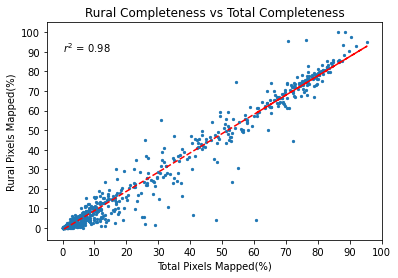

In [43]:
x = munic_completeness.munic_completeness
y = munic_completeness.rural_complete
r, _ = pearsonr(x, y)

plt.scatter(x, y, s=5)
plt.xlabel("Total Pixels Mapped(%)")
plt.ylabel("Rural Pixels Mapped(%)")
plt.title("Rural Completeness vs Total Completeness")
plt.xticks(np.arange(0, 110, 10))
plt.yticks(np.arange(0, 110, 10))
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x, p(x), "r--")
plt.text(0, 90, "$r^{2}$ = " + str(round(r, 2)))
# plt.savefig('rural-total-completeness.png', dpi=300)

### Poverty Incidence vs Municipal Completeness

In [44]:
phl_poverty.Mun_Code = "PH" + phl_poverty.Mun_Code.map("{:0>9}".format).astype("str")

In [45]:
phl_poverty.dtypes

Mun_Code                   object
Poverty_Incidence_2015    float64
dtype: object

In [46]:
munic_completeness = munic_completeness.merge(
    phl_poverty, left_on="ADM3_PCODE", right_on="Mun_Code", how="inner"
)

In [47]:
munic_completeness.head()

,ADM3_PCODE,munic_completeness,rural_complete,urban_complete,Mun_Code,Poverty_Incidence_2015
0,PH012809000,60.857217,61.460889,50.000000,PH012809000,11.7
1,PH012812000,77.335859,77.836231,75.469283,PH012812000,6.6
2,PH012820000,76.596280,75.925386,80.804388,PH012820000,7.7
3,PH012903000,81.727420,80.644316,90.184049,PH012903000,11.2
4,PH012906000,67.948205,66.282216,92.948718,PH012906000,10.4


Text(0, 90, '$r^{2}$ = -0.26')

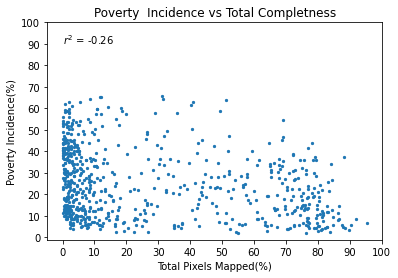

In [48]:
x = munic_completeness.munic_completeness
y = munic_completeness.Poverty_Incidence_2015
r, _ = pearsonr(x, y)

plt.scatter(x, y, s=5)
plt.ylabel("Poverty Incidence(%)")
plt.xlabel("Total Pixels Mapped(%)")
plt.title("Poverty  Incidence vs Total Completness")
plt.xticks(np.arange(0, 110, 10))
plt.yticks(np.arange(0, 110, 10))
# z = np.polyfit(x, y, 1)
# p = np.poly1d(z)
# plt.plot(x,p(x),"r--")
plt.text(0, 90, "$r^{2}$ = " + str(round(r, 2)))
# plt.savefig('poverty-total-completeness.png', dpi=300)